Temperature Sweep:   0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:185: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


CSVファイル 'Control_Experiment_SNR_vs_T_ClassicalOnly.csv' が生成されました。
PDFファイル 'Fig4_Control_Experiment_ClassicalOnly.pdf' が生成されました。


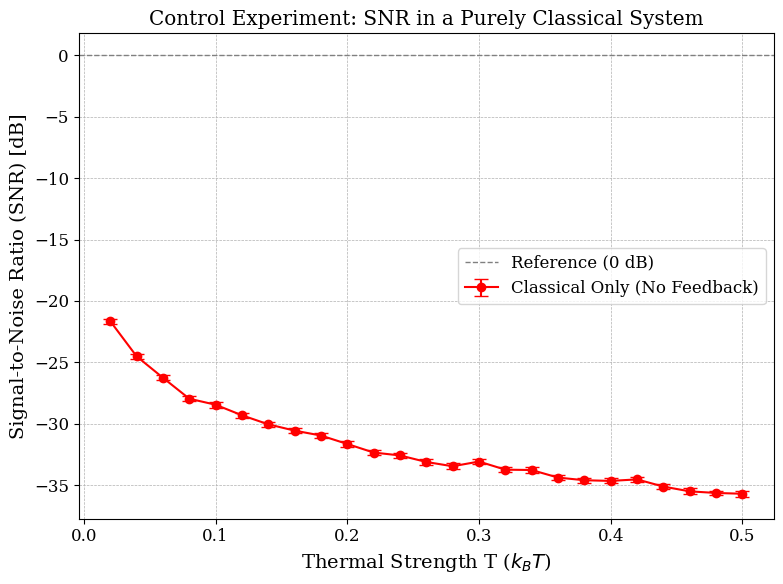

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.fft import fft
from tqdm.notebook import tqdm

# --- グラフ品質と一貫性のための設定 ---
# Adobe Acrobatでのフォント埋め込み問題を解決 (Type 42フォント)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# 論文v3, v4との一貫性を保つためのフォント設定
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# --- シミュレーションパラメータ (v5.0の図2と条件を統一) ---
# 物理パラメータ
M = 50.0  # 障壁の質量
k_mech = 10.0  # 自己復元力のバネ定数
gamma = 1.5  # 散逸係数 (固定)
k_B = 1.0  # ボルツマン定数 (無次元化)

# 時間・空間パラメータ
dt = 0.005  # 時間ステップ
T_total = 200.0  # 総シミュレーション時間
N_steps = int(T_total / dt)
t = np.linspace(0, T_total, N_steps)

# 実験パラメータ
N_runs = 100  # 各温度での試行回数 (統計的信頼性のため)
T_values = np.linspace(0.0, 0.5, 26) # 温度スイープ範囲 (v5.0の図2に合わせる)

# --- 対照実験の核心: 量子フィードバックをゼロにする ---
def get_forces(z, v, T):
    """
    力を計算する関数。
    対照実験のため、F_feedbackは常に0とする。
    """
    F_restoring = -k_mech * z
    F_dissipation = -gamma * v
    # 熱ゆらぎ項 (ランジュバン方程式)
    F_thermal = np.sqrt(2 * gamma * k_B * T / dt) * np.random.normal(0, 1)

    # --- ここが重要: フィードバック力を意図的にゼロに設定 ---
    F_feedback = 0.0

    F_total = F_restoring + F_dissipation + F_thermal + F_feedback
    return F_total

# --- SNR計算関数 (v5.0のものを流用) ---
def calculate_snr(trajectory, dt):
    """
    時系列データからSNRを計算する。
    この実験では信号がないため、SNRは低くなるはず。
    """
    N = len(trajectory)
    yf = fft(trajectory)
    power_spectrum = (2.0/N * np.abs(yf[0:N//2]))**2

    # 信号がないため、ノイズフロアのみを考慮
    noise_level = np.mean(power_spectrum)

    # 信号パワーをゼロと仮定
    signal_power = 1e-9 # 便宜的な微小値

    snr = 10 * np.log10(signal_power / noise_level) if noise_level > 0 else -np.inf
    return snr

# --- シミュレーション実行 ---
results = []
# 温度Tでループ
for T in tqdm(T_values, desc="Temperature Sweep"):
    snr_runs = []
    # 各温度でN_runs回シミュレーションを実行
    for _ in range(N_runs):
        z = 0.0  # 初期位置
        v = 0.0  # 初期速度
        z_trajectory = np.zeros(N_steps)

        for i in range(N_steps):
            F = get_forces(z, v, T)
            a = F / M
            v += a * dt
            z += v * dt
            z_trajectory[i] = z

        snr = calculate_snr(z_trajectory, dt)
        snr_runs.append(snr)

    mean_snr = np.mean(snr_runs)
    sem_snr = np.std(snr_runs) / np.sqrt(N_runs) # 標準誤差
    results.append({'Temperature': T, 'Mean_SNR': mean_snr, 'SEM_SNR': sem_snr})

# --- 結果をDataFrameに変換し、CSVとして保存 ---
df_results = pd.DataFrame(results)
csv_filename = 'Control_Experiment_SNR_vs_T_ClassicalOnly.csv'
df_results.to_csv(csv_filename, index=False)
print(f"CSVファイル '{csv_filename}' が生成されました。")

# --- グラフ描画 ---
fig, ax = plt.subplots(figsize=(8, 6))

T_plot = df_results['Temperature']
mean_snr_plot = df_results['Mean_SNR']
sem_snr_plot = df_results['SEM_SNR']

ax.errorbar(T_plot, mean_snr_plot, yerr=sem_snr_plot, fmt='-o', capsize=5,
            label='Classical Only (No Feedback)', color='red')

# v5.0の図2との比較のため、基準線を引く (オプション)
ax.axhline(0, ls='--', color='gray', lw=1, label='Reference (0 dB)')

ax.set_xlabel('Thermal Strength T ($k_B T$)')
ax.set_ylabel('Signal-to-Noise Ratio (SNR) [dB]')
ax.set_title('Control Experiment: SNR in a Purely Classical System')
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# --- PDFとして保存 ---
pdf_filename = 'Fig4_Control_Experiment_ClassicalOnly.pdf'
plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
print(f"PDFファイル '{pdf_filename}' が生成されました。")

# --- 生成したファイルをデスクトップにダウンロード ---
# from google.colab import files
# files.download(csv_filename)
# files.download(pdf_filename)